In [1]:
import numpy as np
import os 

import centroid_extraction
# import centroid_preprocessing

In [8]:
# define parent directory
root_dir = "Z:/Isabel/arena/camera_calibration_files/"
img_date = input("input date of image acquisition (YYMMDD): ")
# calibration_folder = f"{img_date}_calibration_videos/"
calibration_folder = f"{img_date}_calibration_videos/"
calibration_path = os.path.join(root_dir, calibration_folder)
tmp_local_root = "C:/Users/ilow1/Documents/code/bird_pose_tracking/"

# to save raw centroids
raw_dir_local = f"{tmp_local_root}calibration_files/raw_centroids/"
laser_rgb_idx = 1 # specify idx for R, G, or B laser

# to save preprocessed centroids
save_dir = f"{tmp_local_root}calibration_files/preprocessed_centroids/"

input date of image acquisition (YYMMDD): 240507


In [3]:
''' First, extract the raw centroids from each frame of each camera '''
cam_folders = centroid_extraction.get_image_folders(calibration_path)

['blue_cam_images', 'green_cam_images', 'red_cam_images', 'yellow_cam_images']


processing 25050 images for blue_cam...


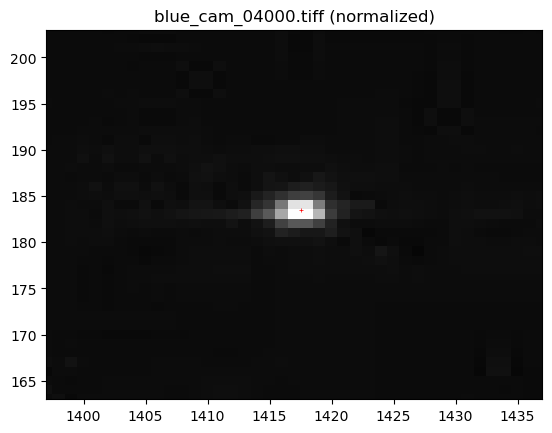

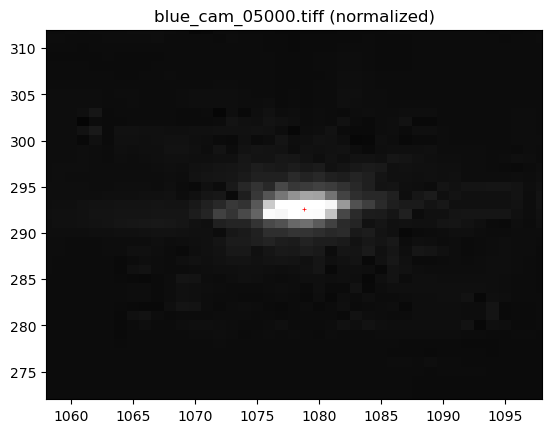

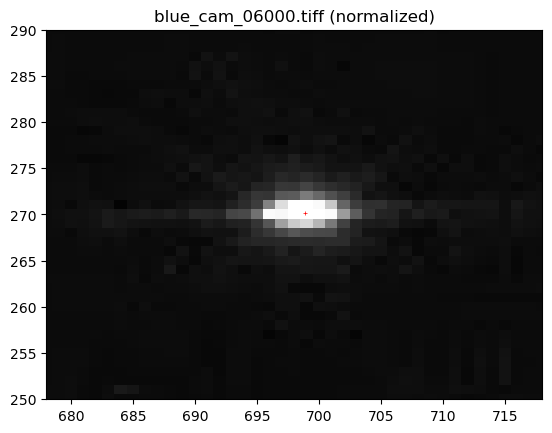

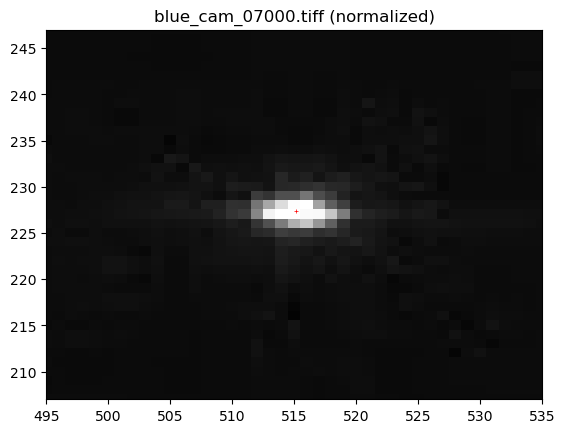

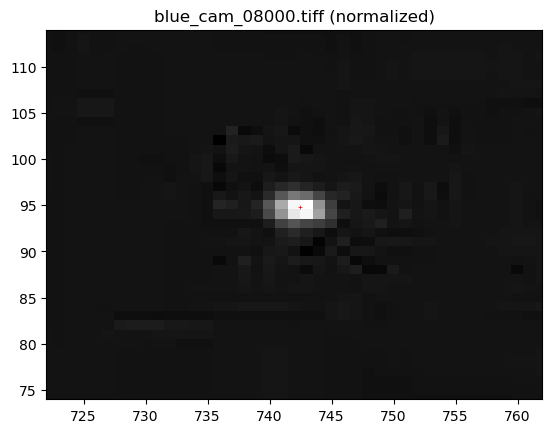

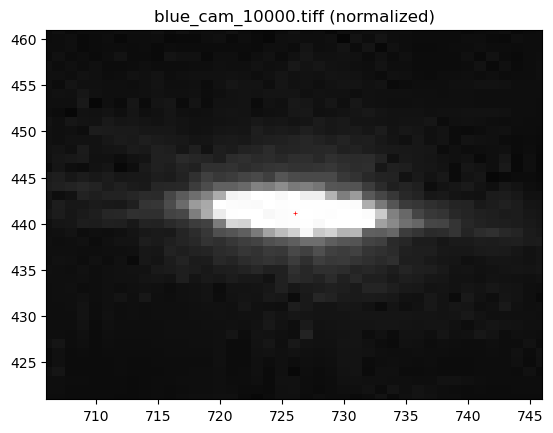

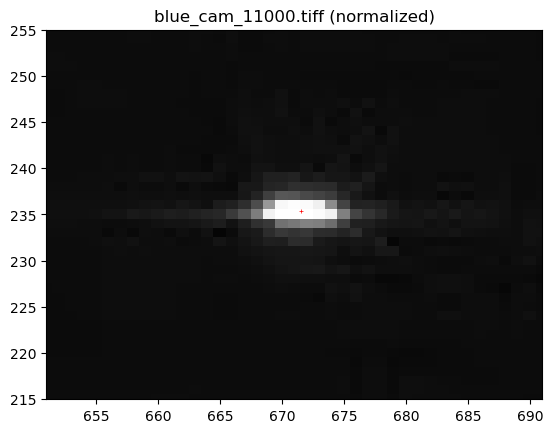

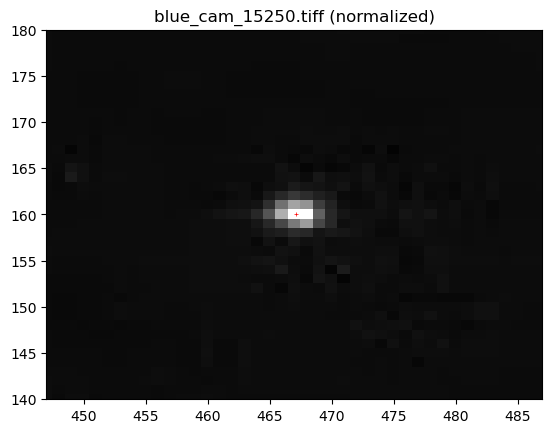

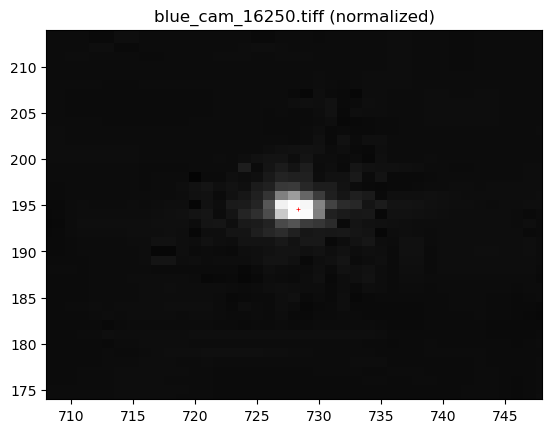

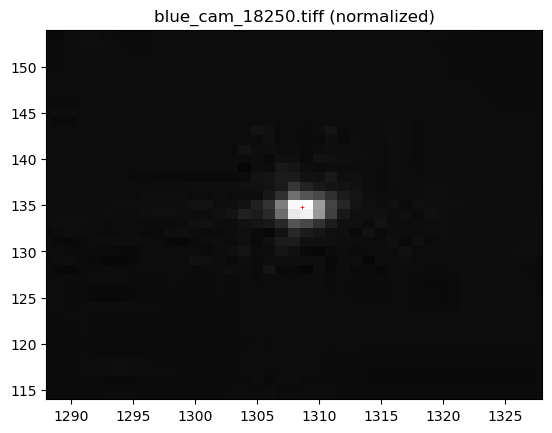

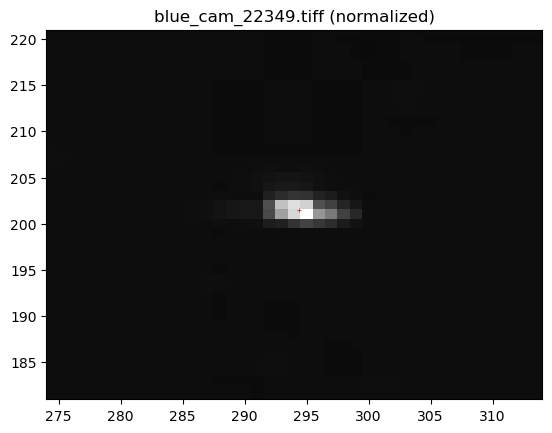

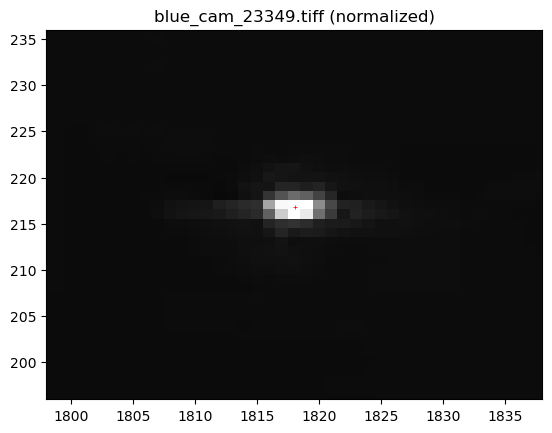

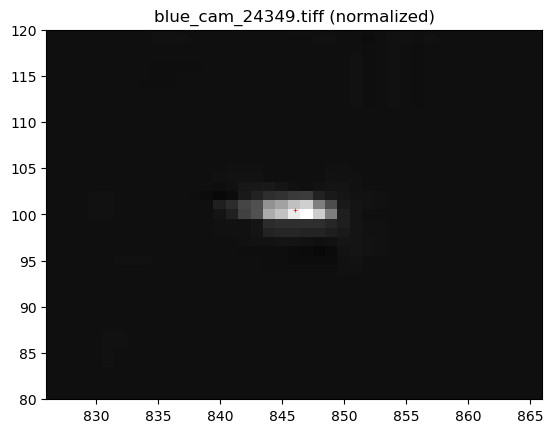

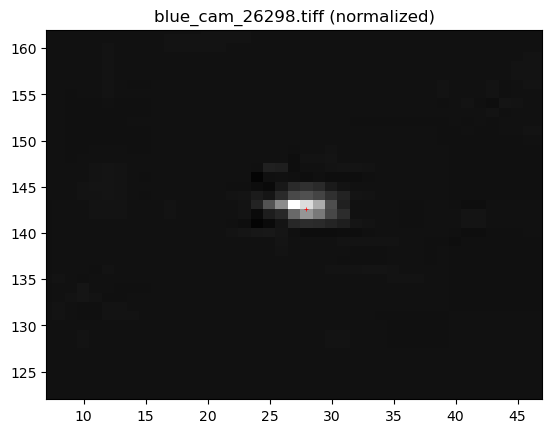

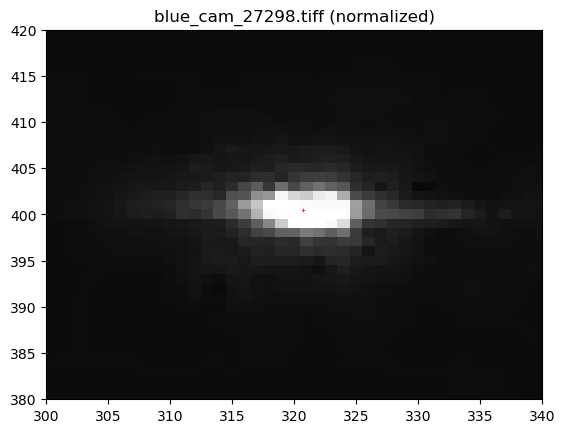

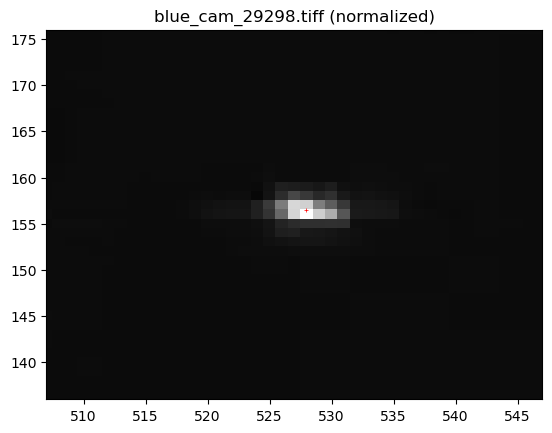

9661 excluded
blue_cam: found 15389 well-defined centroids


processing 25050 images for green_cam...


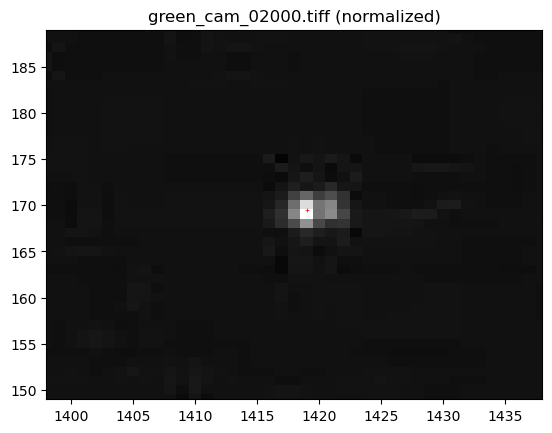

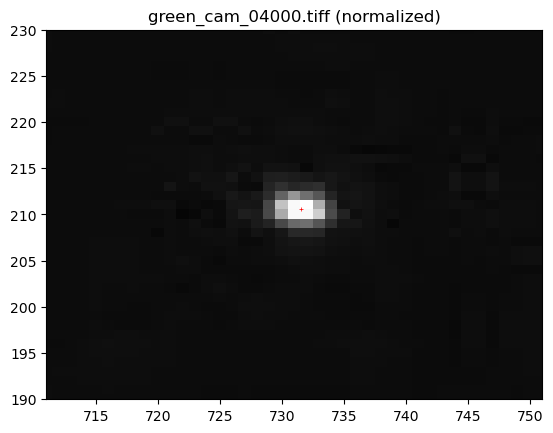

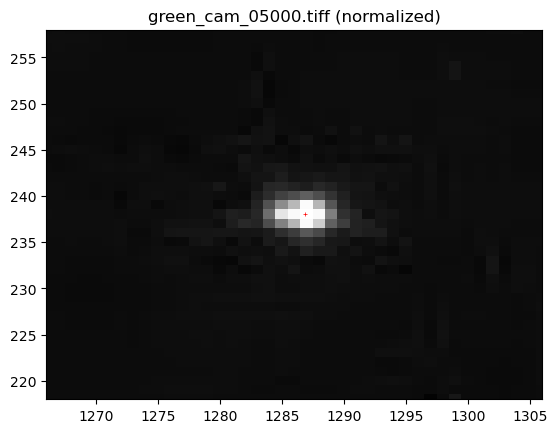

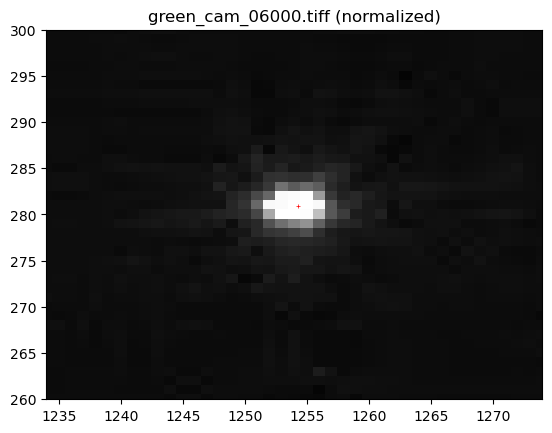

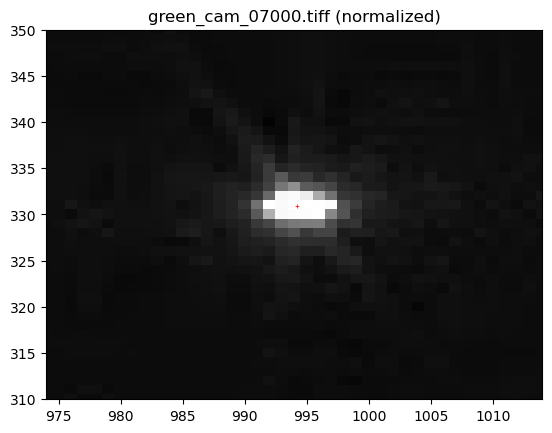

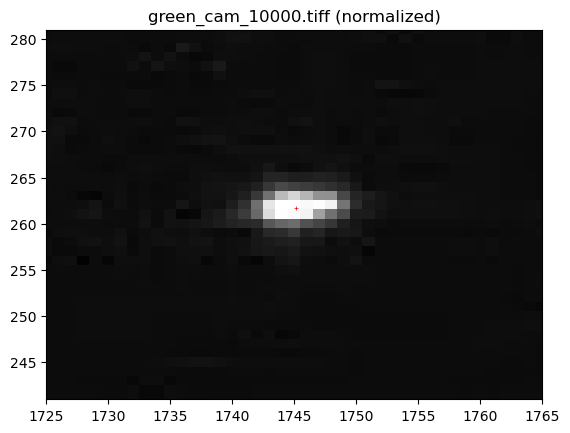

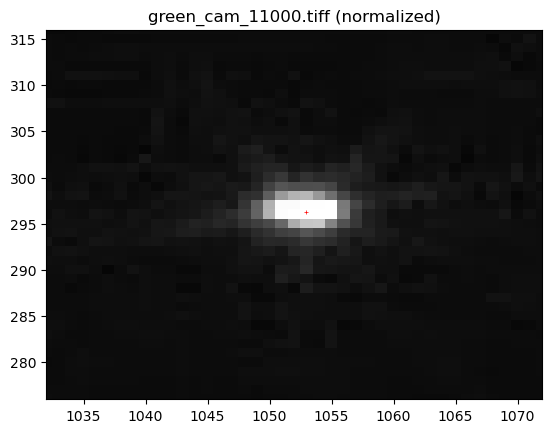

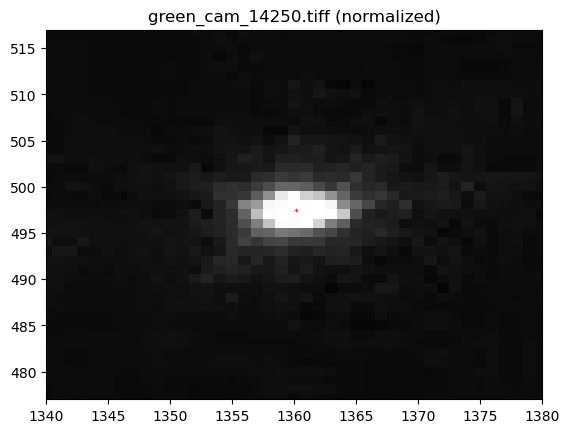

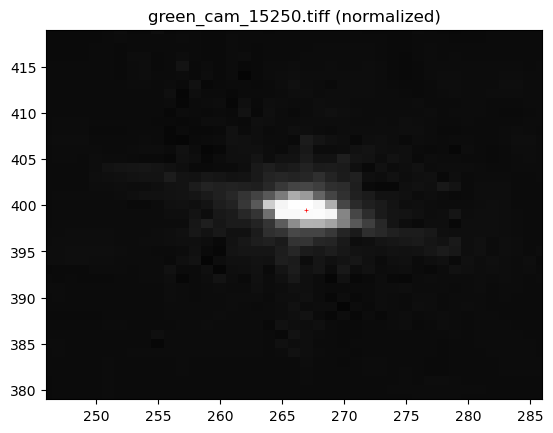

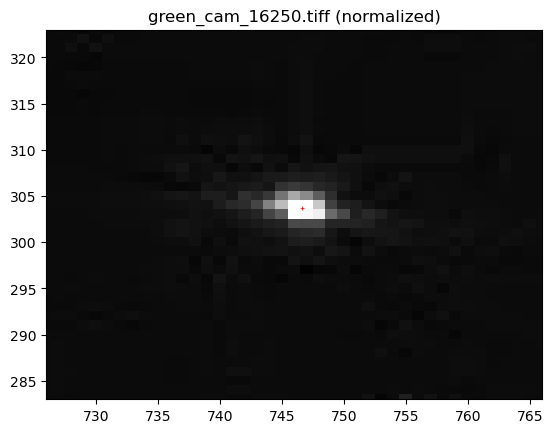

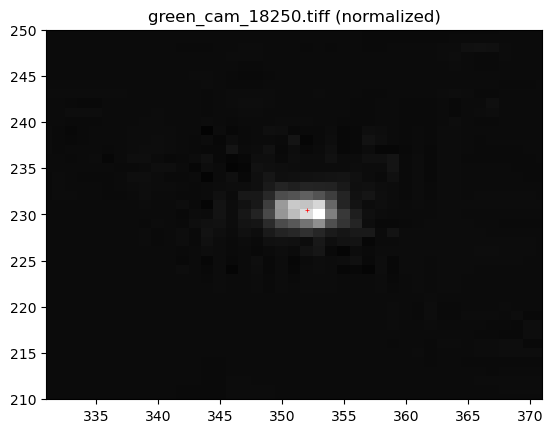

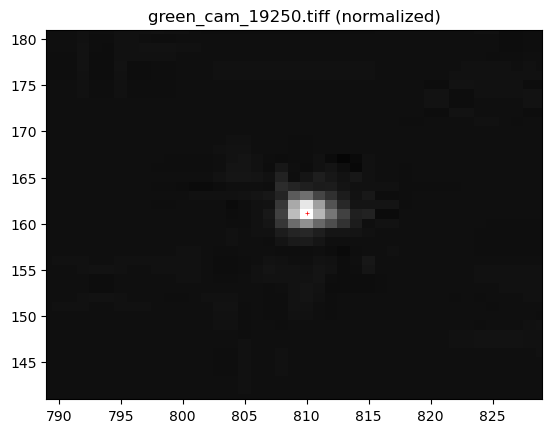

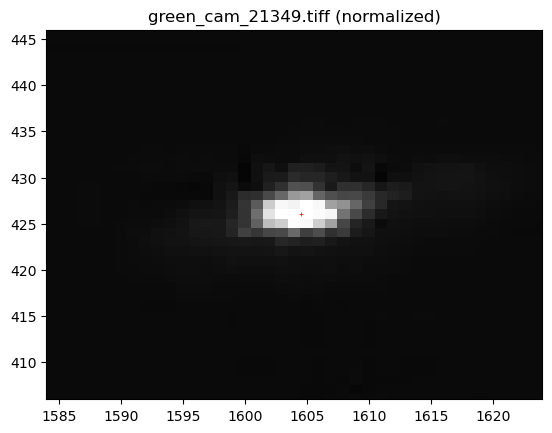

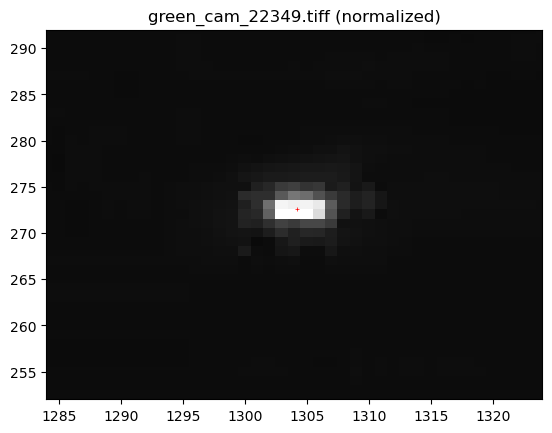

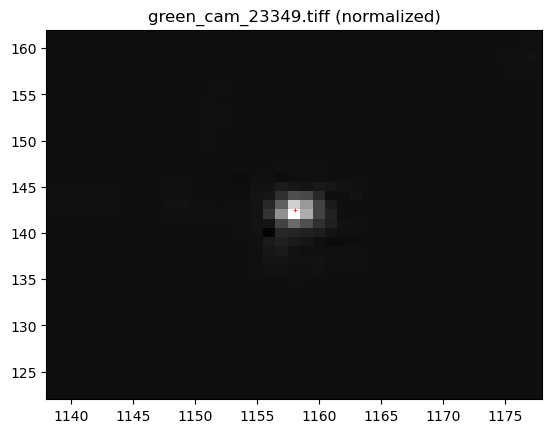

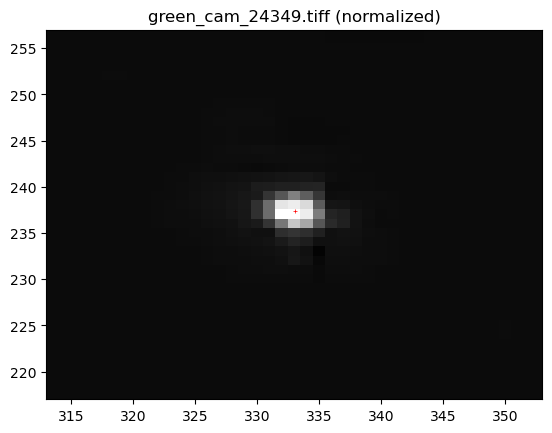

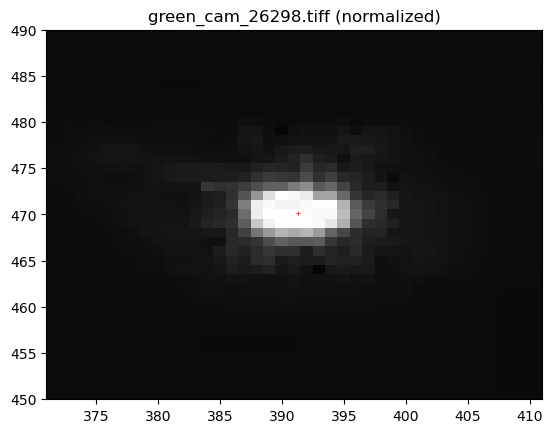

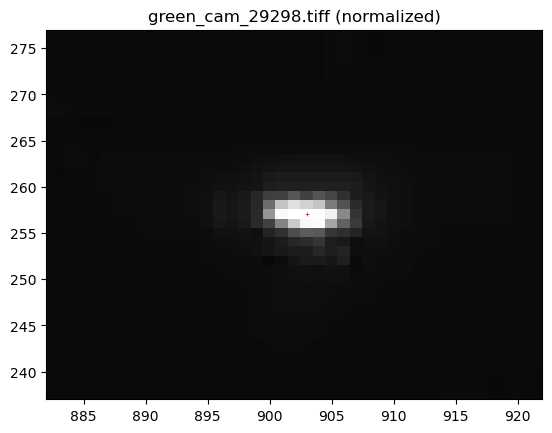

8597 excluded
green_cam: found 16453 well-defined centroids


processing 25050 images for red_cam...


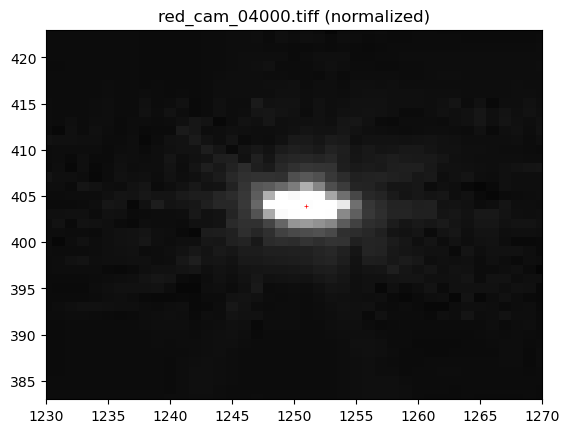

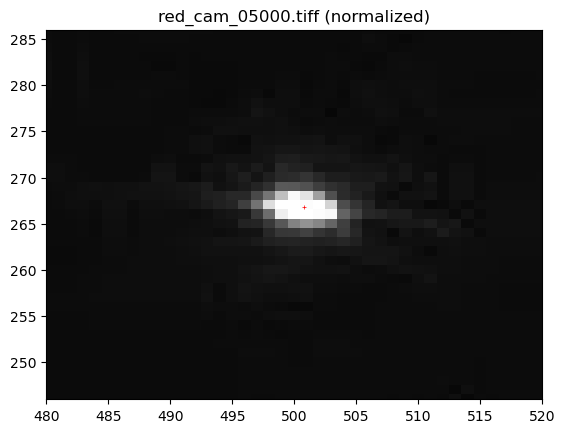

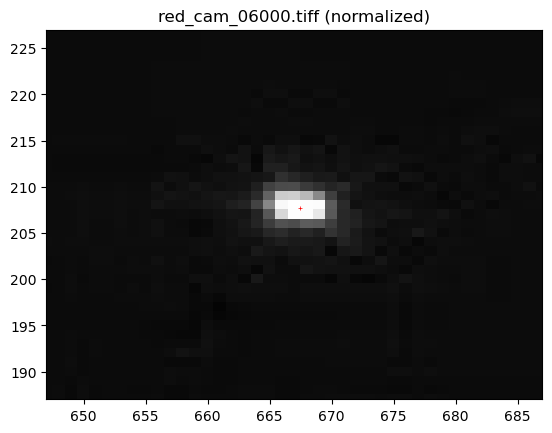

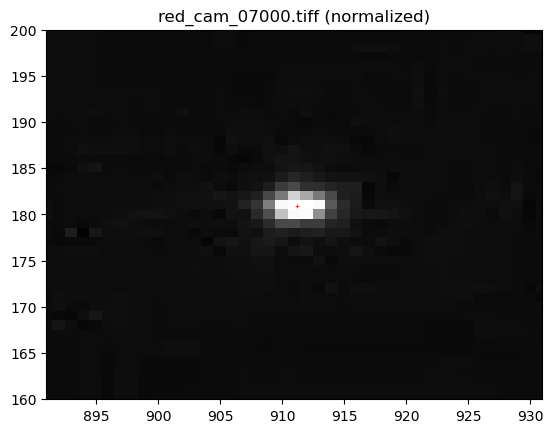

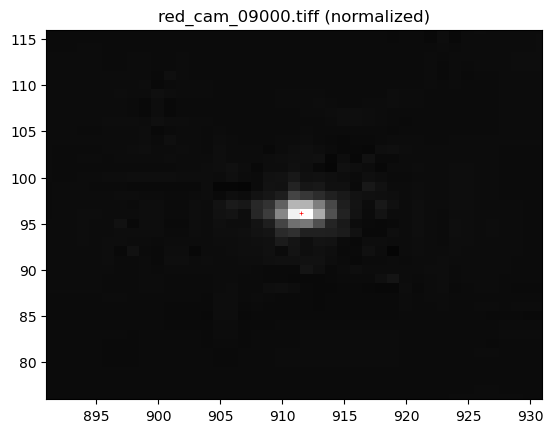

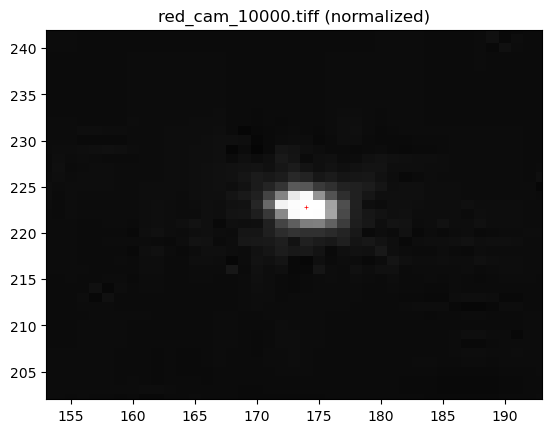

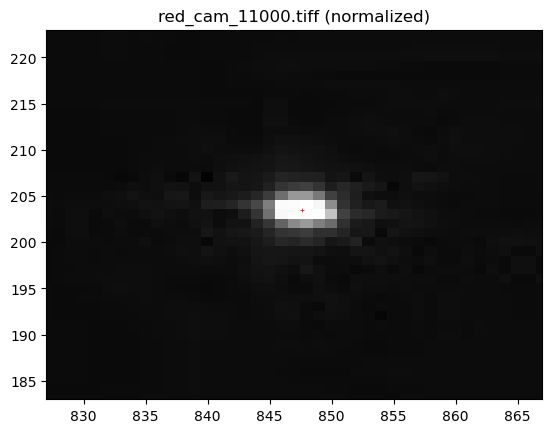

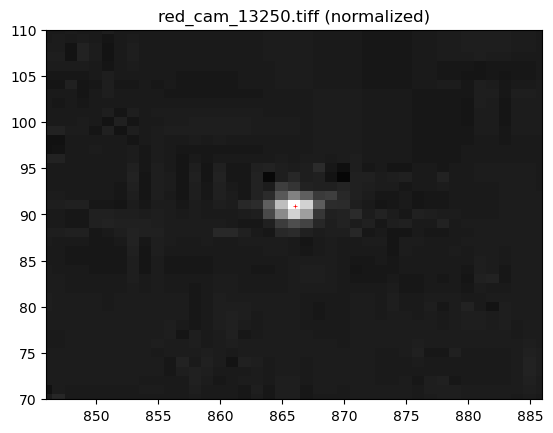

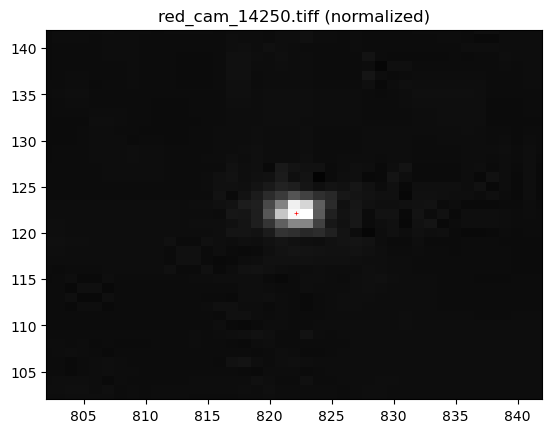

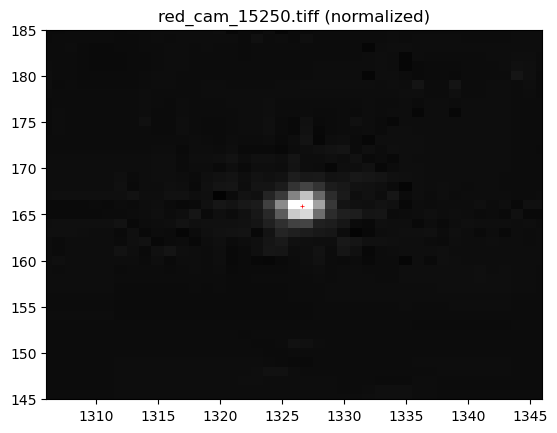

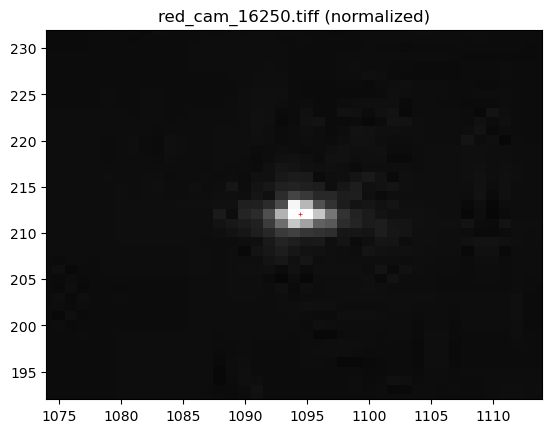

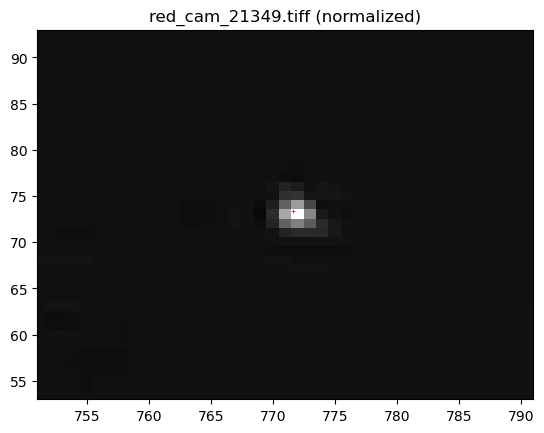

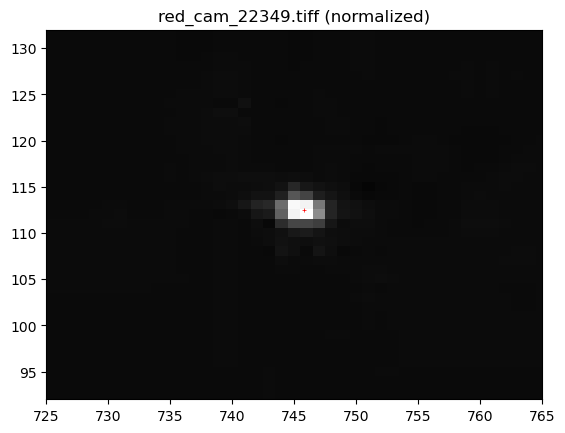

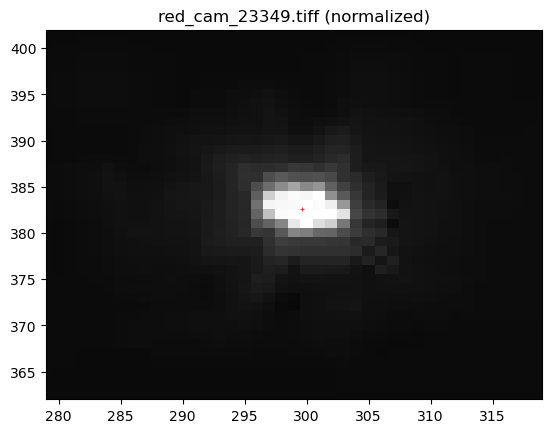

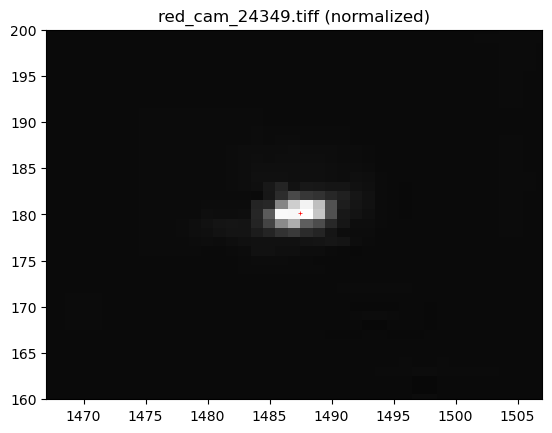

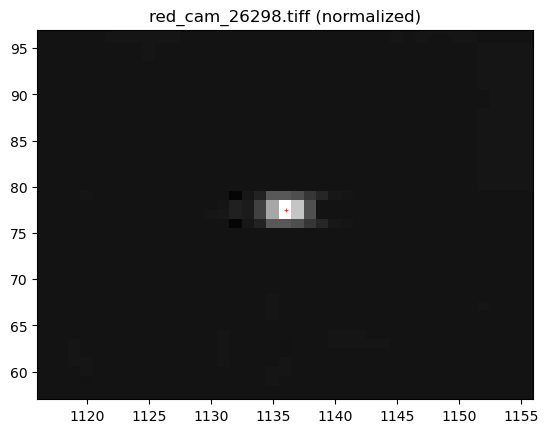

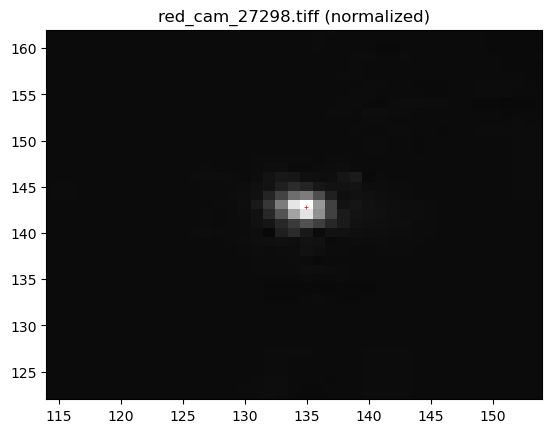

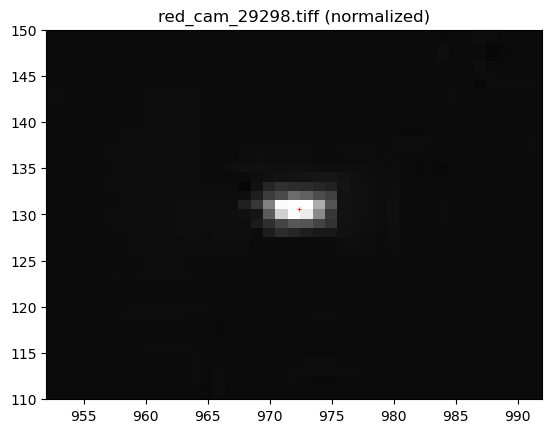

8386 excluded
red_cam: found 16664 well-defined centroids


processing 25050 images for yellow_cam...


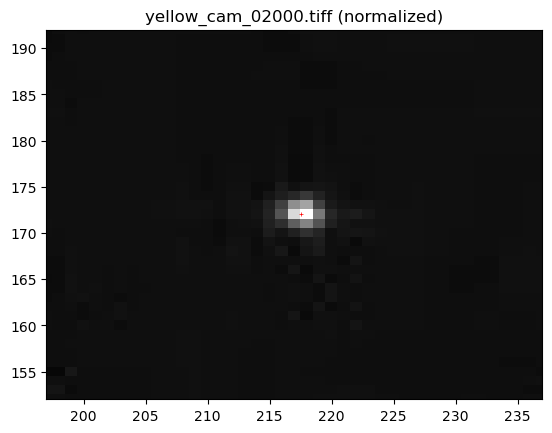

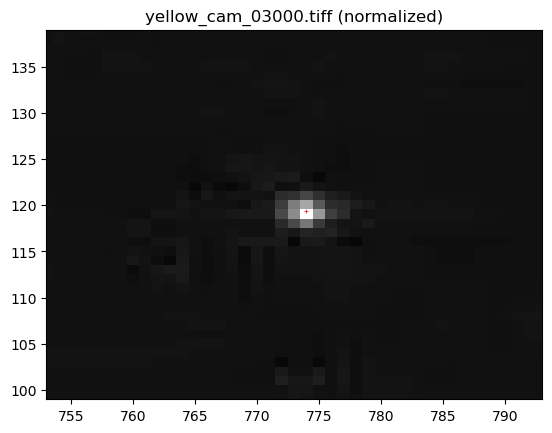

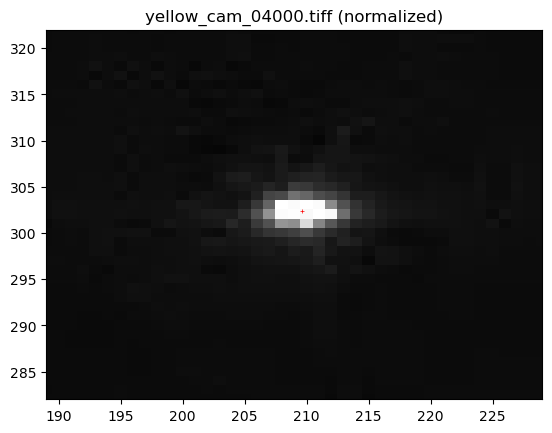

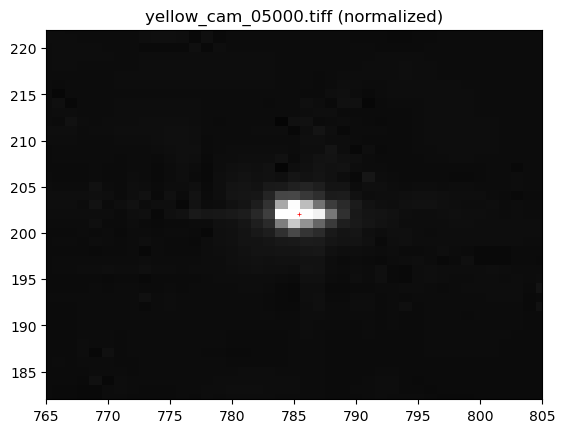

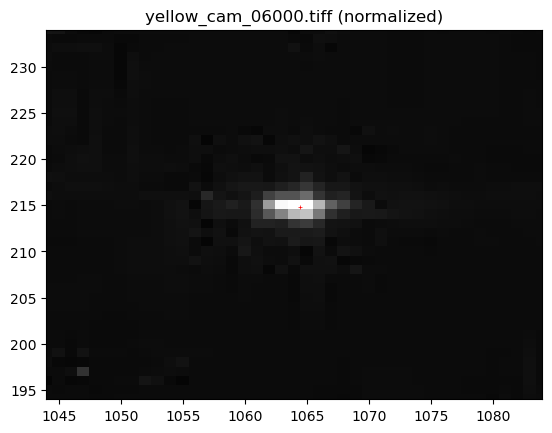

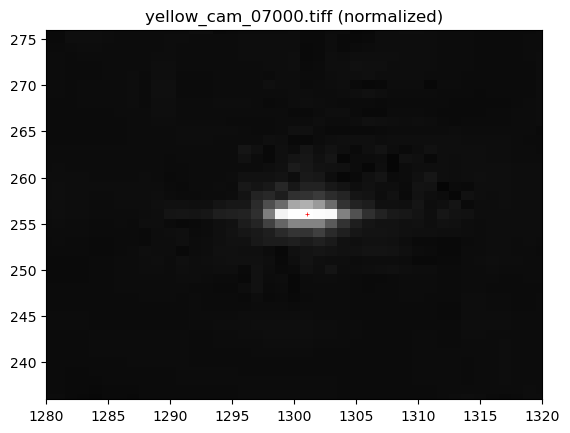

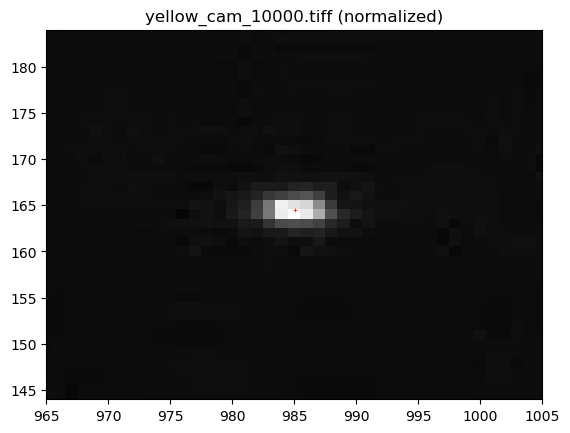

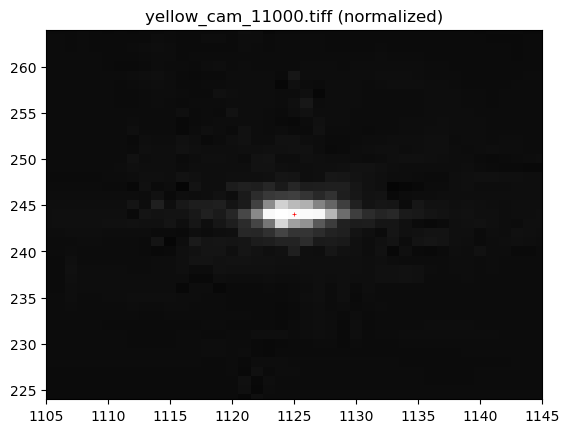

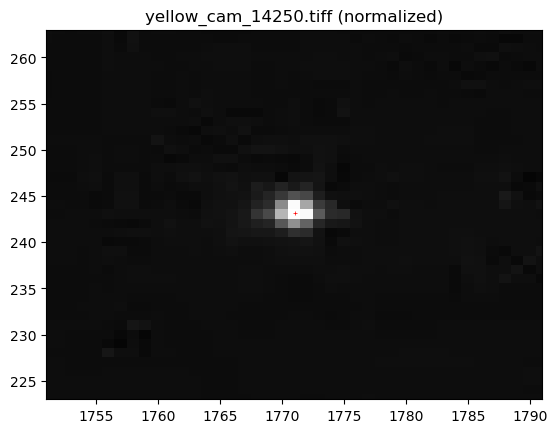

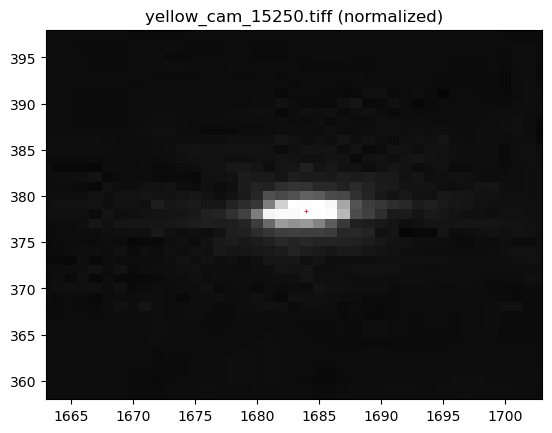

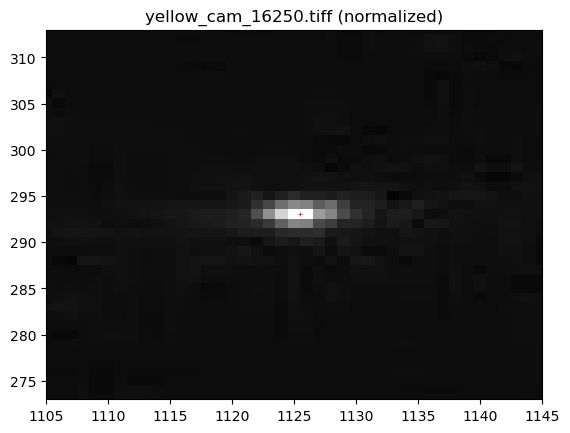

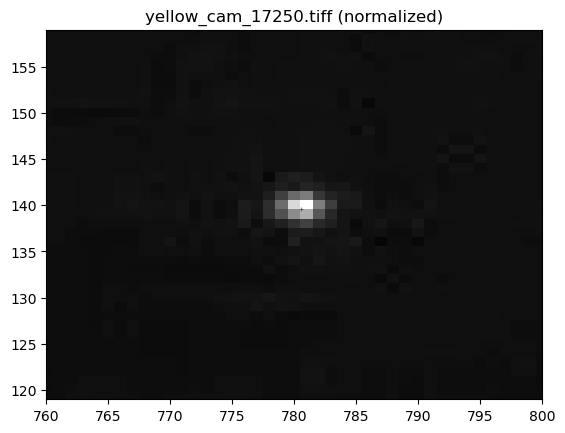

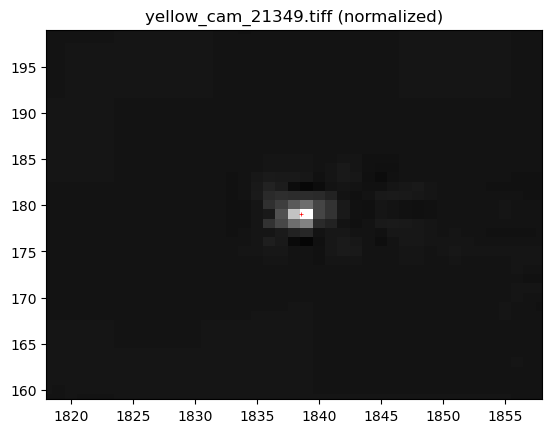

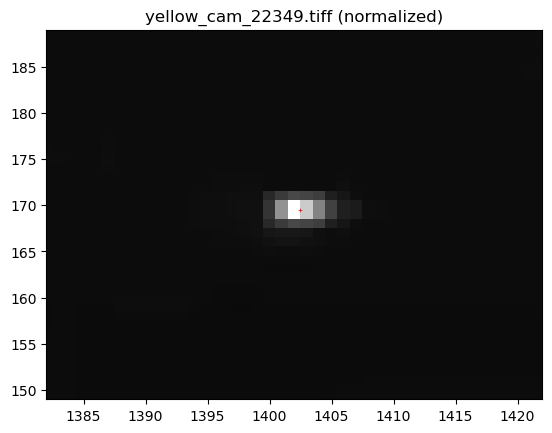

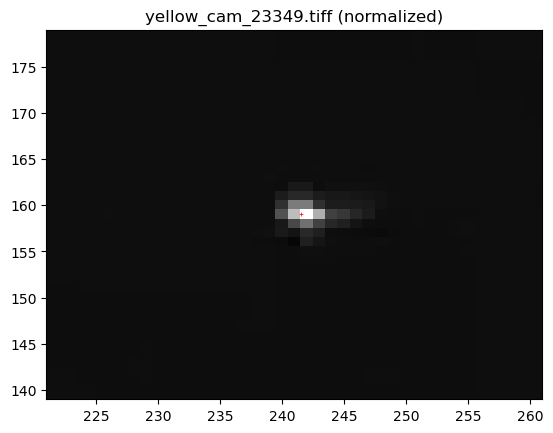

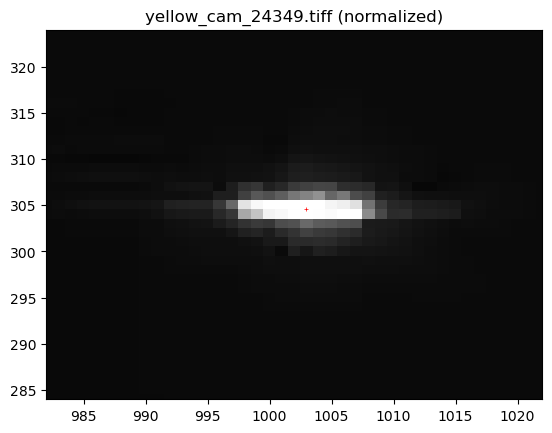

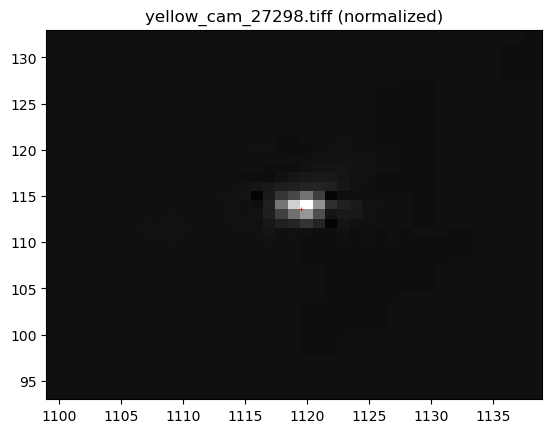

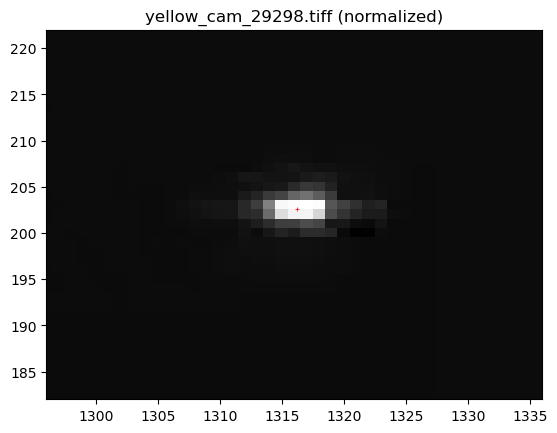

10204 excluded
yellow_cam: found 14846 well-defined centroids




In [4]:
for cam_folder in cam_folders:
    cam_id, areas, centroids, blob_count = centroid_extraction.extract_centroids(calibration_path,
                                                                                 cam_folder,
                                                                                 laser_rgb_idx=1)
    centroid_file_name = f"{img_date}_{cam_id}_centroids"

    # save the centroid info remotely to the locker
    out_locker = f"{calibration_path}{centroid_file_name}"
    np.savez(out_locker, areas, centroids, blob_count)

    # save the centroid info to this repo
    out_local = f"{raw_dir_local}{centroid_file_name}"
    np.savez(out_local, areas, centroids, blob_count)

In [3]:
''' Next, filter out frames where the point was not visible to all cameras and save the remaining "good points" '''
cam_ids = ['red_cam', 'yellow_cam', 'green_cam', 'blue_cam']
# cam_ids = ['rBack', 'rFront', 'rTop', 'lBack', 'lFront', 'lTop'] # SC cam IDs
centroid_files = []
for cam_id in cam_ids:
    centroid_files.append(f"{img_date}_{cam_id}_centroids.npz")

In [4]:
centroid_files

['240507_red_cam_centroids.npz',
 '240507_yellow_cam_centroids.npz',
 '240507_green_cam_centroids.npz',
 '240507_blue_cam_centroids.npz']

In [9]:
'''
5/8/24 trying a new indexing method more similar to SC
keep all points, regardless of whether they are visible to multiple cameras
note that this differ's from Rob's protocol (Janelia)
'''
# determine maximum number of images across cameras
n_images = 0
for f in centroid_files:
    with np.load(f"{calibration_path}{f}") as data:
        areas = data['arr_0']
        n_images = np.max((n_images, areas.shape[0]))
n_cams = len(cam_ids) # number of cameras

In [7]:
# set the z value associated with each image
possible_z_values = np.asarray([1, 2]) # inches
start_img_idx = np.asarray([0, 10250+7750]) # start idx for images with each z value

z_values = np.zeros(n_images)
for i in range(possible_z_values.shape[0]):
    img_idx = start_img_idx[i]
    z_values[img_idx:] = possible_z_values[i]

z_values /= 13 # normalized arena units

In [12]:
pts = np.empty(shape=(n_images, 2, n_cams))
in_pts = np.zeros(shape=(n_images, n_cams), dtype=bool)
# pts_z_vals = np.empty(shape=(n_images, n_cams))
for i, f in enumerate(centroid_files):
    # load this camera's centroids
    filename = f"{raw_dir_local}{f}"
    with np.load(filename) as data:
        areas = data['arr_0'][:n_images]
        centroids = data['arr_1'][:n_images]

    # save the centroid locations and note nans
    pts[:, :, i] = centroids.copy()
    nan_pts = np.isnan(areas)
    in_pts[:, i] = np.abs(nan_pts - 1)

In [13]:
# remove frames with points visible on fewer than n_cams_see cameras
n_cams_see = 2
n_visible = np.sum(in_pts, axis=1)
visible_idx = n_visible >= n_cams_see

# get the total number of good points
n_pts_total = np.sum(n_visible[visible_idx])

# keep only the points visible to the desired number of cameras
in_pts = in_pts[visible_idx]
pts = pts[visible_idx]
# z_values = z_values[visible_idx]

In [14]:
# flip xy
pts = np.flip(pts, axis=1)

In [15]:
# get the indices for all frames with just one point visible
camera_ind = np.zeros(shape=(n_pts_total,), dtype=int)
point_ind = np.zeros(shape=(n_pts_total,), dtype=int)
points_2d = np.zeros(shape=(n_pts_total, 2), dtype=float)
# point_z = np.zeros(shape=(n_pts_total,), dtype=float)
ind_end = 0
for i in range(n_cams): 
    # get the visible points for this camera
    good_pts = np.squeeze(pts[in_pts[:, i], :, i])
    n_pts_now = good_pts.shape[0]
    
    # set the index range
    ind_start = ind_end
    ind_end = ind_start + n_pts_now
    
    # get the point values and indices
    points_2d[ind_start:ind_end] = good_pts
    camera_ind[ind_start:ind_end] = i
    point_ind[ind_start:ind_end] = np.where(in_pts[:, i])[0]
#     point_z[ind_start:ind_end] = z_values[in_pts[:, i]].squeeze()

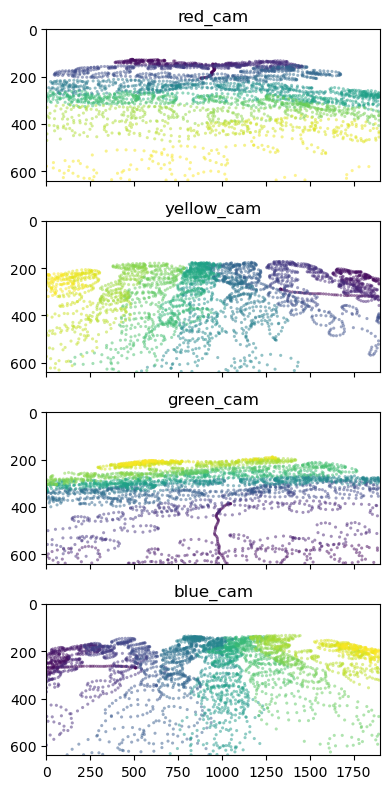

In [18]:
''' plot the centroids for each camera to check '''
import matplotlib.pyplot as plt
fig, axs = plt.subplots(n_cams, 1, sharex=True, figsize=(4, 8))

for i in range(n_cams):
    # data params
    ind2d = camera_ind==i
    cam_points = points_2d[ind2d].squeeze()
    n_pts = cam_points.shape[0]
    
    # plot the points
    colors = np.linspace(0, 1, n_pts)
    axs[i].scatter(cam_points[:, 0],
                       cam_points[:, 1],
                       s=5, lw=0, c=colors, alpha=0.5)
    
    # flip y-axis (camera y increases down from the camera)
    axs[i].set_xlim([0, 1900])
    axs[i].set_ylim([0, 640])
    axs[i].invert_yaxis()
    
    axs[i].title.set_text(f'{cam_ids[i]}')  
    
plt.tight_layout()
plt.show()

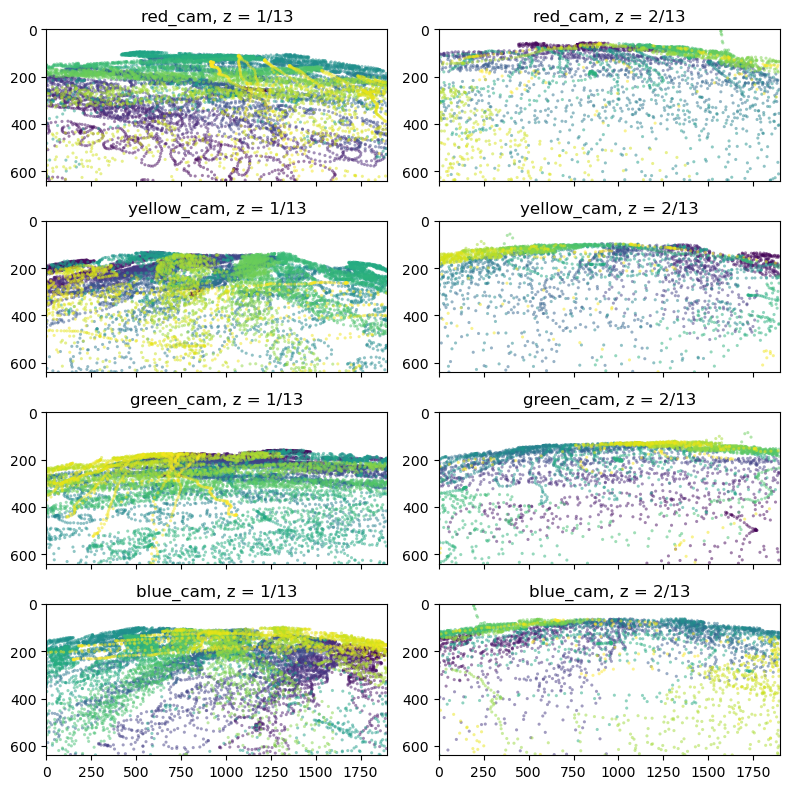

In [12]:
''' plot the centroids for each camera to check '''
import matplotlib.pyplot as plt
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))

for i in range(n_cams):
    # data params
    ind2d = camera_ind==i
    cam_points = points_2d[ind2d].squeeze()
    cam_zs = point_z[ind2d].squeeze()
    n_pts = cam_points.shape[0]
    
    # plot the points
    colors = np.linspace(0, 1, n_pts)
    axs[i, 0].scatter(cam_points[cam_zs==1/13, 0],
                       cam_points[cam_zs==1/13, 1],
                       s=5, lw=0, c=colors[cam_zs==1/13], alpha=0.5)
    axs[i, 1].scatter(cam_points[cam_zs==2/13, 0],
                   cam_points[cam_zs==2/13, 1],
                   s=5, lw=0, c=colors[cam_zs==2/13], alpha=0.5)
    
    # flip y-axis (camera y increases down from the camera)
    for j in range(2):
        axs[i, j].set_xlim([0, 1900])
        axs[i, j].set_ylim([0, 640])
        axs[i, j].invert_yaxis()
    
    axs[i, 0].title.set_text(f'{cam_ids[i]}, z = 1/13')  
    axs[i, 1].title.set_text(f'{cam_ids[i]}, z = 2/13')  
    
plt.tight_layout()
plt.show()

In [19]:
# save the preprocessed centroid locations and indices
save_centroids = f'{img_date}_centroids.npy'
np.save(f'{save_dir}{save_centroids}', points_2d)

save_camera_ind = f'{img_date}_camera_ind.npy'
np.save(f'{save_dir}{save_camera_ind}', camera_ind)

save_point_ind = f'{img_date}_point_ind.npy'
np.save(f'{save_dir}{save_point_ind}', point_ind)

In [20]:
pts.shape

(3955, 2, 4)

In [15]:
''' initialize the 3D point z locations 
the x and y locations get initialized in Step 2 of the SBA protocol, 
but it might be useful to use the known z heights?
'''
# allocate variables and get red indices
n_pts = in_pts.shape[0]
points_3d = np.zeros(shape=(n_pts, 3))

# define z height (1" = 1/13 normalized coords)
norm_z = z_values
points_3d[:, 2] = norm_z

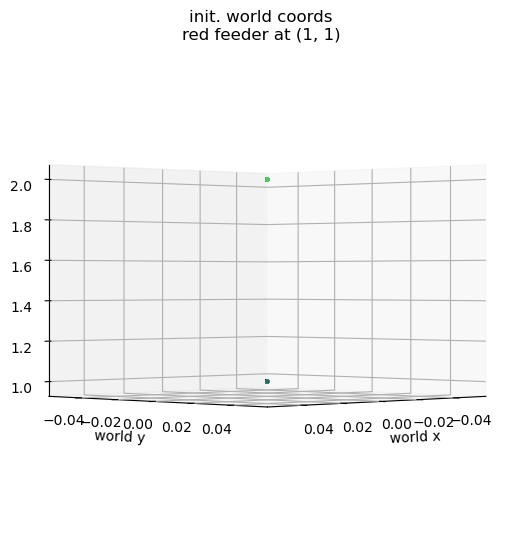

In [18]:
''' plot the estimated 3D coordinates '''
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 4))
ax = plt.axes([0, 0, .6, 1.2], projection='3d')

x_pts = points_3d[:, 0].copy()
y_pts = points_3d[:, 1].copy()
z_pts = points_3d[:, 2].copy()*13
colors = np.linspace(0, 1, n_pts)
ax.scatter(
        x_pts, y_pts, z_pts,
        c=colors, cmap='viridis',
        alpha=0.5, lw=0, s=10)
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_zlim(-1, 1)

ax.set_xlabel('world x')
ax.set_ylabel('world y')
ax.set_zlabel('world z')

ax.view_init(azim=45, elev=0)
ax.set_title(f'init. world coords\nred feeder at (1, 1)')

plt.show()

In [19]:
# save the initial estimate for the 3D coords
save_centroids_3d = f'{img_date}_init_3d.npy'
np.save(f'{save_dir}{save_centroids_3d}', points_3d)

In [12]:
''' prior to 5/8/24 kept only points visible to all cameras '''
# data params
# determine the minimum number of images across cameras
n_images = 10000
for f in centroid_files:
    with np.load(f"{calibration_path}{f}") as data:
        areas = data['arr_0']
        n_images = np.min((n_images, areas.shape[0]))
n_cams = len(cam_ids) # number of cameras

# to store final centroids
pts = np.empty(shape=(n_images, 2, n_cams))
nan_pts = np.zeros(shape=(n_images, n_cams), dtype=bool)

In [13]:
for i, f in enumerate(centroid_files):
    # load this camera's centroids
    filename = f"{raw_dir_local}{f}"
    with np.load(filename) as data:
        areas = data['arr_0'][:n_images]
        centroids = data['arr_1'][:n_images]

    # save the centroid locations and note nans
    pts[:, :, i] = centroids.copy()
    nan_pts[:, i] = np.isnan(areas)

In [14]:
# find frames where there was no point or multiple points for 1 or more of the cameras
# keep only single points visible to all cameras
in_pts = np.zeros(shape=(n_images,), dtype=bool)
for i in range(n_images):
    in_pts[i] = (not any(nan_pts[i, :]))
good_pts = pts[in_pts, :, :] 
print(f"n good points = {good_pts.shape[0]}")

# save the preprocessed centroid locations
np.savez(save_file, good_pts)

n good points = 3615


In [15]:
good_pts.shape

(3615, 2, 4)

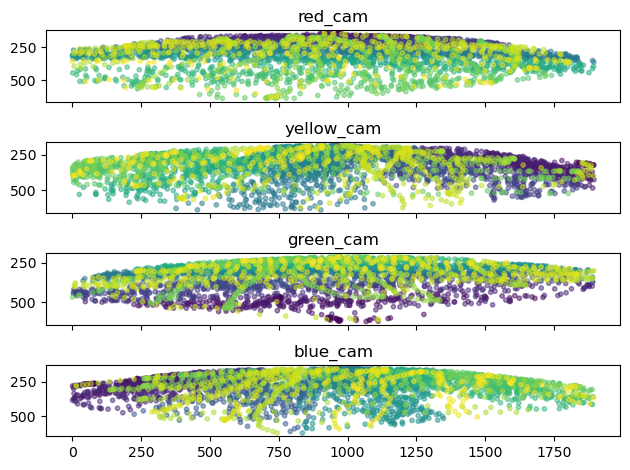

In [16]:
# plot centroid locations for each camera to check
import matplotlib.pyplot as plt
fig, axs = plt.subplots(n_cams, 1, sharex=True)
for i in range(n_cams):
    centroids = good_pts[:, :, i].squeeze()
    colors = np.linspace(0, 1, good_pts.shape[0])
    axs[i].scatter(centroids[:, 1], centroids[:, 0],\
                    s=10, c=colors, alpha=0.5)
    axs[i].title.set_text(cam_ids[i])
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()